<a href="https://colab.research.google.com/github/MDSKR/MLDL_paper-review/blob/main/RCNN/RCNN_pascalVOC_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

code review from https://herbwood.tistory.com/6?category=867198

original code from https://github.com/object-detection-algorithm/R-CNN

In [ ]:
# http://host.robots.ox.ac.uk/pascal/VOC/voc2007/
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
# !tar -xvf VOCtrainval_06-Nov-2007.tar

# https://pjreddie.com/projects/pascal-voc-dataset-mirror/
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!tar -xvf VOCtrainval_06-Nov-2007.tar

### 1. PASCAL VOC 데이터셋 다운로드 및 "car" class 해당하는 데이터만 추출

https://github.com/object-detection-algorithm/R-CNN/blob/master/py/utils/data/pascal_voc.py

https://github.com/object-detection-algorithm/R-CNN/blob/master/py/utils/data/pascal_voc_car.py

PASCAL VOC 2007 데이터에 대한 설명 참조
(https://ndb796.tistory.com/500)

객체 탐지(object detection)만 다룬다면 Annotations, ImageSets, JPEGImages 세 가지 폴더만 이용

1) 주석(Annotation) : xml 파일

  ① 클래스(Class): 오브젝트의 클래스가 무엇인지

  ② 바운딩 박스(Bounding Box): 오브젝트가 어디에 있는지

  ③ View: 각각의 오브젝트의 방향성 정보

  ④ Truncated: 오브젝트가 해당 이미지에 온전히 표현되지 못하고 잘려나갔는지

  ⑤ Difficult: 인식하기 어려운지

2) ImageSets : txt 파일

모든 이미지 파일명과 텍스트 파일명과 동일한 class에 해당하는지 여부(해당할 경우 1, 아닐 경우 -1)

In [ ]:
import numpy as np

def parse_train_val(data_path):
    samples = []

    with open(data_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            res = line.strip().split(' ')
            if len(res) == 3 and int(res[2]) == 1:
                samples.append(res[0])

    return np.array(samples)

In [ ]:
car_train_path = './VOCdevkit/VOC2007/ImageSets/Main/car_train.txt'
car_val_path = './VOCdevkit/VOC2007/ImageSets/Main/car_val.txt'

In [ ]:
samples = {'train': parse_train_val(car_train_path), 'val': parse_train_val(car_val_path)}
# print(samples)

In [ ]:
import random

def sample_train_val(samples):
    for name in ['train', 'val']:
        dataset = samples[name]
        length = len(dataset)

        random_samples = random.sample(range(length), int(length / 10))
        # print(random_samples)
        new_dataset = dataset[random_samples]
        samples[name] = new_dataset

    return samples

In [ ]:
samples = sample_train_val(samples)
print(samples)

{'train': array(['008174', '002804', '005536', '009358', '003555', '009845',
       '006210', '007667', '001937', '008968', '007159', '004873',
       '002411', '007490', '009671', '005273', '005782', '005669',
       '003027', '005566', '004386', '004962', '000367', '009121',
       '007790', '002134', '002180', '000977', '009411', '009045',
       '008037', '007821', '009406', '009718', '002490', '003165',
       '009959'], dtype='<U6'), 'val': array(['003891', '009822', '005979', '006325', '005588', '004087',
       '000653', '006396', '006668', '009116', '008429', '006235',
       '000338', '001862', '007622', '008562', '009053', '003820',
       '009015', '007525', '000233', '008031', '003117', '005988',
       '006918', '000251', '000329', '002566', '003721', '002563',
       '007921', '006206', '002248'], dtype='<U6')}


In [ ]:
voc_annotation_dir = './VOCdevkit/VOC2007/Annotations/'
voc_jpeg_dir = './VOCdevkit/VOC2007/JPEGImages/'

In [ ]:
# car에 해당하는 이미지와 xml 파일을 복사하여 별도의 데이터셋을 구축
import os
import shutil

car_root_dir = './voc_car/'
if not os.path.exists(car_root_dir):
  os.mkdir(car_root_dir)

def save_car(car_samples, data_root_dir, data_annotation_dir, data_jpeg_dir):
    for sample_name in car_samples:
        src_annotation_path = os.path.join(voc_annotation_dir, sample_name + '.xml')
        dst_annotation_path = os.path.join(data_annotation_dir, sample_name + '.xml')
        shutil.copyfile(src_annotation_path, dst_annotation_path)

        src_jpeg_path = os.path.join(voc_jpeg_dir, sample_name + '.jpg')
        dst_jpeg_path = os.path.join(data_jpeg_dir, sample_name + '.jpg')
        shutil.copyfile(src_jpeg_path, dst_jpeg_path)

    csv_path = os.path.join(data_root_dir, 'car.csv')
    np.savetxt(csv_path, np.array(car_samples), fmt='%s')

for name in ['train', 'val']:
  data_root_dir = os.path.join(car_root_dir, name)
  data_annotation_dir = os.path.join(data_root_dir, 'Annotations')
  data_jpeg_dir = os.path.join(data_root_dir, 'JPEGImages')

  if not os.path.exists(data_root_dir):
    os.mkdir(data_root_dir)
  if not os.path.exists(data_annotation_dir):
    os.mkdir(data_annotation_dir)
  if not os.path.exists(data_jpeg_dir):
    os.mkdir(data_jpeg_dir)

  save_car(samples[name], data_root_dir, data_annotation_dir, data_jpeg_dir)

### 2. 각 모델별 annotation 생성

#### selectivesearch.py : opencv에서 제공하는 메서드를 통해 Selective search 알고리즘 수행
https://github.com/object-detection-algorithm/R-CNN/blob/master/py/selectivesearch.py


1) 이미지에 Selective search 알고리즘을 적용하여 region proposals를 추출합니다. 그리고 해당 이미지에 대한 xml 파일을 읽어들여 ground truth box를 파악합니다.

2) region proposals와 ground truth box를 비교하여 IoU 값을 도출하고 0.5 이상인 sample은 positive_list, 0.5 미만인 sample은 negative_list에 저장합니다.

3) 그리고 이미지별 region proposal에 대한 위치를 positive/negative 여부에 따라 서로 다른 csv 파일에 저장합니다. 예를 들어 1111.jpg 파일에서 positive sample에 해당하는 bounding box의 좌표는 1111_1.csv 파일에, negative sample에 해당하는 bounding box는 1111_0.csv 파일에 저장합니다. 


#### create_finetune_data.py : AlexNet fine tune을 수행하기 위한 annotation 생성
https://github.com/object-detection-algorithm/R-CNN/blob/master/py/utils/data/create_finetune_data.py

In [ ]:
finetune_root_dir = './finetune_car/'
if not os.path.exists(finetune_root_dir):
  os.mkdir(finetune_root_dir)

for name in ['train', 'val']:
  dst_root_dir = os.path.join(finetune_root_dir, name)
  dst_annotation_dir = os.path.join(dst_root_dir, 'Annotations')
  dst_jpeg_dir = os.path.join(dst_root_dir, 'JPEGImages')

  if not os.path.exists(dst_root_dir):
    os.mkdir(dst_root_dir)
  if not os.path.exists(dst_annotation_dir):
    os.mkdir(dst_annotation_dir)
  if not os.path.exists(dst_jpeg_dir):
    os.mkdir(dst_jpeg_dir)

In [ ]:
!pip install xmltodict

In [ ]:
import xmltodict

def parse_xml(xml_path):
    with open(xml_path, 'rb') as f:
        xml_dict = xmltodict.parse(f)
        # print(xml_dict)

        bndboxs = list()
        objects = xml_dict['annotation']['object']
        if isinstance(objects, list):
            for obj in objects:
                obj_name = obj['name']
                difficult = int(obj['difficult'])
                if 'car'.__eq__(obj_name) and difficult != 1:
                    bndbox = obj['bndbox']
                    bndboxs.append((int(bndbox['xmin']), int(bndbox['ymin']), int(bndbox['xmax']), int(bndbox['ymax'])))
        elif isinstance(objects, dict):
            obj_name = objects['name']
            difficult = int(objects['difficult'])
            if 'car'.__eq__(obj_name) and difficult != 1:
                bndbox = objects['bndbox']
                bndboxs.append((int(bndbox['xmin']), int(bndbox['ymin']), int(bndbox['xmax']), int(bndbox['ymax'])))
        else:
            pass

        return np.array(bndboxs)

In [ ]:
def iou(pred_box, target_box):
    """
    Calculate candidate suggestions and label the IoU of the bounding box
    :param pred_box: size is [4]
    :param target_box: size is [N, 4]
    :return: [N]
    """
    if len(target_box.shape) == 1:
        target_box = target_box[np.newaxis, :]

    xA = np.maximum(pred_box[0], target_box[:, 0])
    yA = np.maximum(pred_box[1], target_box[:, 1])
    xB = np.minimum(pred_box[2], target_box[:, 2])
    yB = np.minimum(pred_box[3], target_box[:, 3])
    # Calculate the intersection area
    intersection = np.maximum(0.0, xB - xA) * np.maximum(0.0, yB - yA)
    # Calculate the area of two bounding boxes
    boxAArea = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    boxBArea = (target_box[:, 2] - target_box[:, 0]) * (target_box[:, 3] - target_box[:, 1])

    scores = intersection / (boxAArea + boxBArea - intersection)
    return scores

In [ ]:
def region_proposals(annotation_path, jpeg_path, gs):

    img = cv2.imread(jpeg_path)

    gs.setBaseImage(img)
    gs.switchToSelectiveSearchQuality()
    
    # region proposals
    rects = gs.process()
    rects[:, 2] += rects[:, 0]
    rects[:, 3] += rects[:, 1]

    bndboxs = parse_xml(annotation_path) # ground truth boxes

    # get size of the biggest bounding box(region proposals)
    maximum_bndbox_size = 0
    for bndbox in bndboxs:
        xmin, ymin, xmax, ymax = bndbox
        bndbox_size = (ymax - ymin) * (xmax - xmin)
        if bndbox_size > maximum_bndbox_size:
            maximum_bndbox_size = bndbox_size

    # Comparing all region proposals and ground truth
    # return a list of iou results for each region proposals
    iou_list = list()
    for rect in rects:
      scores = iou(rect, bndboxs)
      iou_list.append(max(scores))

    return iou_list, rects, maximum_bndbox_size, bndboxs

In [ ]:
import cv2

def parse_annotation_jpeg(annotation_path, jpeg_path, gs):

    iou_list, rects, maximum_bndbox_size, bndboxs = region_proposals(annotation_path, jpeg_path, gs)

    positive_list = list()
    negative_list = list()

    for i in range(len(iou_list)):
        xmin, ymin, xmax, ymax = rects[i]
        rect_size = (ymax - ymin) * (xmax - xmin)

        iou_score = iou_list[i]
        # When fine-tuning the pre-trained CNN model
        # positive : iou >= 0.5
        # negative : iou < 0.5
        # Only the bounding box with iou greater than 0.5 is saved
        if iou_score >= 0.5:
            positive_list.append(rects[i])

        # negative : iou < 0.5 And if it is more than 20% of the largest bounding box
        if 0 < iou_list[i] < 0.5 and rect_size > maximum_bndbox_size / 5.0:
            negative_list.append(rects[i])
        else:
            pass

    return positive_list, negative_list

In [ ]:
import time

gs = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
for name in ['train', 'val']:
    total_num_positive = 0
    total_num_negative = 0

    samples = np.loadtxt(os.path.join(car_root_dir, name, 'car.csv'), dtype = np.str)

    src_csv_path = os.path.join(car_root_dir, name, 'car.csv')
    dst_csv_path = os.path.join(finetune_root_dir, name, 'car.csv')
    shutil.copyfile(src_csv_path, dst_csv_path)
    for sample_name in samples:
        since = time.time()

        src_annotation_path = os.path.join(car_root_dir, name, 'Annotations', sample_name + '.xml')
        src_jpeg_path = os.path.join(car_root_dir, name, 'JPEGImages', sample_name + '.jpg')

        positive_list, negative_list = parse_annotation_jpeg(src_annotation_path, src_jpeg_path, gs)
        total_num_positive += len(positive_list)
        total_num_negative += len(negative_list)

        dst_annotation_dir = os.path.join(finetune_root_dir, name, 'Annotations')
        dst_jpeg_dir = os.path.join(finetune_root_dir, name, 'JPEGImages')
        dst_annotation_positive_path = os.path.join(dst_annotation_dir, sample_name + '_1' + '.csv')
        dst_annotation_negative_path = os.path.join(dst_annotation_dir, sample_name + '_0' + '.csv')
        dst_jpeg_path = os.path.join(dst_jpeg_dir, sample_name + '.jpg')
        shutil.copyfile(src_jpeg_path, dst_jpeg_path)

        np.savetxt(dst_annotation_positive_path, np.array(positive_list), fmt='%d', delimiter=' ')
        np.savetxt(dst_annotation_negative_path, np.array(negative_list), fmt='%d', delimiter=' ')

        time_elapsed = time.time() - since
        print('parse {}.png in {:.0f}m {:.0f}s'.format(sample_name, time_elapsed // 60, time_elapsed % 60))
    print('%s positive num: %d' % (name, total_num_positive))
    print('%s negative num: %d' % (name, total_num_negative))

parse 008174.png in 0m 7s
parse 002804.png in 0m 7s
parse 005536.png in 0m 8s
parse 009358.png in 0m 7s
parse 003555.png in 0m 7s
parse 009845.png in 0m 9s
parse 006210.png in 0m 7s
parse 007667.png in 0m 7s
parse 001937.png in 0m 7s
parse 008968.png in 0m 7s
parse 007159.png in 0m 9s
parse 004873.png in 0m 8s
parse 002411.png in 0m 7s
parse 007490.png in 0m 8s
parse 009671.png in 0m 7s
parse 005273.png in 0m 8s
parse 005782.png in 0m 6s
parse 005669.png in 0m 6s
parse 003027.png in 0m 6s
parse 005566.png in 0m 7s
parse 004386.png in 0m 6s
parse 004962.png in 0m 7s
parse 000367.png in 0m 8s
parse 009121.png in 0m 7s
parse 007790.png in 0m 7s
parse 002134.png in 0m 8s
parse 002180.png in 0m 8s
parse 000977.png in 0m 7s
parse 009411.png in 0m 7s
parse 009045.png in 0m 8s
parse 008037.png in 0m 7s
parse 007821.png in 0m 7s
parse 009406.png in 0m 6s
parse 009718.png in 0m 9s
parse 002490.png in 0m 8s
parse 003165.png in 0m 4s
parse 009959.png in 0m 7s
train positive num: 6167
train negativ

#### create_classifier_data.py : linear SVM 학습을 위한 annotation 생성
https://github.com/object-detection-algorithm/R-CNN/blob/master/py/utils/data/create_classifier_data.py


In [ ]:
def parse_annotation_jpeg_svm(annotation_path, jpeg_path, gs):

    iou_list, rects, maximum_bndbox_size, bndboxs = region_proposals(annotation_path, jpeg_path, gs)

    positive_list = list()
    negative_list = list()
    for i in range(len(iou_list)):
        xmin, ymin, xmax, ymax = rects[i]
        rect_size = (ymax - ymin) * (xmax - xmin)

        iou_score = iou_list[i]
        if 0 < iou_score <= 0.3 and rect_size > maximum_bndbox_size / 5.0:
            negative_list.append(rects[i])
        else:
            pass

    return bndboxs, negative_list

In [ ]:
classifier_root_dir = './classifier_car/'
if not os.path.exists(classifier_root_dir):
  os.mkdir(classifier_root_dir)

gs = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
for name in ['train', 'val']:
    dst_root_dir = os.path.join(classifier_root_dir, name)
    dst_annotation_dir = os.path.join(dst_root_dir, 'Annotations')
    dst_jpeg_dir = os.path.join(dst_root_dir, 'JPEGImages')

    if not os.path.exists(dst_root_dir):
      os.mkdir(dst_root_dir)
    if not os.path.exists(dst_annotation_dir):
      os.mkdir(dst_annotation_dir)
    if not os.path.exists(dst_jpeg_dir):
      os.mkdir(dst_jpeg_dir)

    total_num_positive = 0
    total_num_negative = 0

    samples = np.loadtxt(os.path.join(car_root_dir, name, 'car.csv'), dtype = np.str)

    src_csv_path = os.path.join(car_root_dir, name, 'car.csv')
    dst_csv_path = os.path.join(classifier_root_dir, name, 'car.csv')
    shutil.copyfile(src_csv_path, dst_csv_path)
    for sample_name in samples:
        since = time.time()

        src_annotation_path = os.path.join(car_root_dir, name, 'Annotations', sample_name + '.xml')
        src_jpeg_path = os.path.join(car_root_dir, name, 'JPEGImages', sample_name + '.jpg')

        positive_list, negative_list = parse_annotation_jpeg_svm(src_annotation_path, src_jpeg_path, gs)
        total_num_positive += len(positive_list)
        total_num_negative += len(negative_list)

        dst_annotation_positive_path = os.path.join(dst_annotation_dir, sample_name + '_1' + '.csv')
        dst_annotation_negative_path = os.path.join(dst_annotation_dir, sample_name + '_0' + '.csv')
        dst_jpeg_path = os.path.join(dst_jpeg_dir, sample_name + '.jpg')
        shutil.copyfile(src_jpeg_path, dst_jpeg_path)
        
        # Save positive and negative sample labels
        np.savetxt(dst_annotation_positive_path, np.array(positive_list), fmt='%d', delimiter=' ')
        np.savetxt(dst_annotation_negative_path, np.array(negative_list), fmt='%d', delimiter=' ')

        time_elapsed = time.time() - since
        print('parse {}.png in {:.0f}m {:.0f}s'.format(sample_name, time_elapsed // 60, time_elapsed % 60))
    print('%s positive num: %d' % (name, total_num_positive))
    print('%s negative num: %d' % (name, total_num_negative))

parse 008174.png in 0m 7s
parse 002804.png in 0m 7s
parse 005536.png in 0m 7s
parse 009358.png in 0m 7s
parse 003555.png in 0m 7s
parse 009845.png in 0m 9s
parse 006210.png in 0m 7s
parse 007667.png in 0m 7s
parse 001937.png in 0m 7s
parse 008968.png in 0m 8s
parse 007159.png in 0m 9s
parse 004873.png in 0m 7s
parse 002411.png in 0m 7s
parse 007490.png in 0m 7s
parse 009671.png in 0m 7s
parse 005273.png in 0m 8s
parse 005782.png in 0m 6s
parse 005669.png in 0m 6s
parse 003027.png in 0m 6s
parse 005566.png in 0m 7s
parse 004386.png in 0m 6s
parse 004962.png in 0m 7s
parse 000367.png in 0m 8s
parse 009121.png in 0m 7s
parse 007790.png in 0m 7s
parse 002134.png in 0m 8s
parse 002180.png in 0m 8s
parse 000977.png in 0m 7s
parse 009411.png in 0m 7s
parse 009045.png in 0m 8s
parse 008037.png in 0m 7s
parse 007821.png in 0m 7s
parse 009406.png in 0m 6s
parse 009718.png in 0m 9s
parse 002490.png in 0m 8s
parse 003165.png in 0m 4s
parse 009959.png in 0m 7s
train positive num: 65
train negative 

#### create_bbox_regression_data.py : Bounding box regressor 학습을 위한 annotation 생성
https://github.com/object-detection-algorithm/R-CNN/blob/master/py/utils/data/create_bbox_regression_data.py

In [ ]:
voc_car_train_dir = './voc_car/train'
# ground truth
gt_annotation_dir = os.path.join(voc_car_train_dir, 'Annotations')
jpeg_dir = os.path.join(voc_car_train_dir, 'JPEGImages')

classifier_car_train_dir = './finetune_car/train'
# positive
positive_annotation_dir = os.path.join(classifier_car_train_dir, 'Annotations')


dst_root_dir = './bbox_regression/'
dst_jpeg_dir = os.path.join(dst_root_dir, 'JPEGImages')
dst_bndbox_dir = os.path.join(dst_root_dir, 'bndboxs')
dst_positive_dir = os.path.join(dst_root_dir, 'positive')

if not os.path.exists(dst_root_dir):
  os.mkdir(dst_root_dir)
if not os.path.exists(dst_jpeg_dir):
  os.mkdir(dst_jpeg_dir)
if not os.path.exists(dst_bndbox_dir):
  os.mkdir(dst_bndbox_dir)
if not os.path.exists(dst_positive_dir):
  os.mkdir(dst_positive_dir)

samples = np.loadtxt(os.path.join(voc_car_train_dir, 'car.csv'), dtype = np.str)

"""
Extract the bounding box coordinates of the label from the voc_car/train directory
Extract the positive sample coordinates of the training set (IoU>=0.5) from the finetune_car/train directory, 
and further extract the bounding box with IoU>0.6
The data set is saved in the bbox_car directory
"""
res_samples = list()
total_positive_num = 0
for sample_name in samples:
    # Extract positive sample bounding box coordinates（IoU>=0.5）
    positive_annotation_path = os.path.join(positive_annotation_dir, sample_name + '_1.csv')
    positive_bndboxes = np.loadtxt(positive_annotation_path, dtype=np.int, delimiter=' ')

    # Extract label bounding box
    gt_annotation_path = os.path.join(gt_annotation_dir, sample_name + '.xml')
    bndboxs = parse_xml(gt_annotation_path)

    # Calculate candidate suggestions that meet the criteria (IoU>0.6)
    positive_list = list()
    if len(positive_bndboxes.shape) == 1 and len(positive_bndboxes) != 0:
        scores = iou(positive_bndboxes, bndboxs)
        if np.max(scores) > 0.6:
            positive_list.append(positive_bndboxes)
    elif len(positive_bndboxes.shape) == 2:
        for positive_bndboxe in positive_bndboxes:
            scores = iou(positive_bndboxe, bndboxs)
            if np.max(scores) > 0.6:
                positive_list.append(positive_bndboxe)
    else:
        pass

    # If there is a positive sample bounding box (IoU>0.6), 
    # then save the corresponding picture and label the bounding box
    if len(positive_list) > 0:
        jpeg_path = os.path.join(jpeg_dir, sample_name + ".jpg")
        dst_jpeg_path = os.path.join(dst_jpeg_dir, sample_name + ".jpg")
        shutil.copyfile(jpeg_path, dst_jpeg_path)
        # Save label bounding box
        dst_bndbox_path = os.path.join(dst_bndbox_dir, sample_name + ".csv")
        np.savetxt(dst_bndbox_path, bndboxs, fmt='%s', delimiter=' ')
        # Save positive sample bounding box
        dst_positive_path = os.path.join(dst_positive_dir, sample_name + ".csv")
        np.savetxt(dst_positive_path, np.array(positive_list), fmt='%s', delimiter=' ')

        total_positive_num += len(positive_list)
        res_samples.append(sample_name)
        print('save {} done'.format(sample_name))
    else:
        print('-------- {} ineligible'.format(sample_name))

dst_csv_path = os.path.join(dst_root_dir, 'car.csv')
np.savetxt(dst_csv_path, res_samples, fmt='%s', delimiter=' ')
print('total positive num: {}'.format(total_positive_num))

save 008174 done
save 002804 done
save 005536 done
save 009358 done
save 003555 done
save 009845 done
save 006210 done
save 007667 done
save 001937 done
save 008968 done
save 007159 done
save 004873 done
save 002411 done
save 007490 done
save 009671 done
save 005273 done
save 005782 done
save 005669 done
save 003027 done
save 005566 done
save 004386 done
save 004962 done
save 000367 done
save 009121 done
save 007790 done
save 002134 done
save 002180 done
save 000977 done
save 009411 done
save 009045 done
save 008037 done
save 007821 done
save 009406 done
save 009718 done
save 002490 done
save 003165 done
save 009959 done
total positive num: 3274


### 3. 모델별 Custom Dataset 정의

#### custom_finetune_dataset.py : AlexNet fine tune하기 위한 Custom Dataset 정의

https://github.com/object-detection-algorithm/R-CNN/blob/a7a66144a1809cde728052b4c392ef7d92fdab97/py/utils/data/custom_finetune_dataset.py

AlexNet 모델은 양성/음성 sample에 해당하는 이미지를 mini batch로 입력받아 학습합니다. CustomFinetuneDataset에서 생성자(__init__)를 통해 앞서 생성한 csv 파일을 읽어들어 postive sample과 negative sample을 서로 다른 리스트에 저장합니다. 그리고 __getitem__ 메서드는 index를 파라미터로 받아, index에 맞는 이미지와 target(양성/음성 여부)를 반환합니다. 

In [ ]:
class CustomFinetuneDataset():
    def __init__(self, root_dir, transform=None):
        samples = np.loadtxt(os.path.join(root_dir, 'car.csv'), dtype=np.str)

        jpeg_images = [cv2.imread(os.path.join(root_dir, 'JPEGImages', sample_name + ".jpg"))
                       for sample_name in samples]

        positive_annotations = [os.path.join(root_dir, 'Annotations', sample_name + '_1.csv')
                                for sample_name in samples]
        negative_annotations = [os.path.join(root_dir, 'Annotations', sample_name + '_0.csv')
                                for sample_name in samples]

        # Bounding box size
        positive_sizes = list()
        negative_sizes = list()
        # Bounding box coordinates
        positive_rects = list()
        negative_rects = list()

        for annotation_path in positive_annotations:
            rects = np.loadtxt(annotation_path, dtype=np.int, delimiter=' ')
            # The existing file is empty or there is only a single line of data in the file
            if len(rects.shape) == 1:
                # Is it a single line
                if rects.shape[0] == 4:
                    positive_rects.append(rects)
                    positive_sizes.append(1)
                else:
                    positive_sizes.append(0)
            else:
                positive_rects.extend(rects)
                positive_sizes.append(len(rects))
        for annotation_path in negative_annotations:
            rects = np.loadtxt(annotation_path, dtype=np.int, delimiter=' ')
            # Same as the positive sample rule
            if len(rects.shape) == 1:
                if rects.shape[0] == 4:
                    negative_rects.append(rects)
                    negative_sizes.append(1)
                else:
                    positive_sizes.append(0)
            else:
                negative_rects.extend(rects)
                negative_sizes.append(len(rects))

        self.transform = transform
        self.jpeg_images = jpeg_images
        self.positive_sizes = positive_sizes
        self.negative_sizes = negative_sizes
        self.positive_rects = positive_rects
        self.negative_rects = negative_rects
        self.total_positive_num = int(np.sum(positive_sizes))
        self.total_negative_num = int(np.sum(negative_sizes))

    def __getitem__(self, index: int):
        # Position the image to which the subscript belongs
        image_id = len(self.jpeg_images) - 1
        if index < self.total_positive_num:
            # Positive sample
            target = 1
            xmin, ymin, xmax, ymax = self.positive_rects[index]
            # Find the image
            for i in range(len(self.positive_sizes) - 1):
                if np.sum(self.positive_sizes[:i]) <= index < np.sum(self.positive_sizes[:(i + 1)]):
                    image_id = i
                    break
            image = self.jpeg_images[image_id][ymin:ymax, xmin:xmax]
        else:
            # Negative sample
            target = 0
            idx = index - self.total_positive_num
            xmin, ymin, xmax, ymax = self.negative_rects[idx]
            # Find the image
            for i in range(len(self.negative_sizes) - 1):
                if np.sum(self.negative_sizes[:i]) <= idx < np.sum(self.negative_sizes[:(i + 1)]):
                    image_id = i
                    break
            image = self.jpeg_images[image_id][ymin:ymax, xmin:xmax]

        # print('index: %d image_id: %d target: %d image.shape: %s [xmin, ymin, xmax, ymax]: [%d, %d, %d, %d]' %
        #       (index, image_id, target, str(image.shape), xmin, ymin, xmax, ymax))
        if self.transform:
            image = self.transform(image)

        return image, target

    def __len__(self) -> int:
        return self.total_positive_num + self.total_negative_num

    def get_positive_num(self) -> int:
        return self.total_positive_num

    def get_negative_num(self) -> int:
        return self.total_negative_num

In [ ]:
from google.colab.patches import cv2_imshow

def test_finetune(idx):
    root_dir = './finetune_car/train'
    train_data_set = CustomFinetuneDataset(root_dir)

    print('positive num: %d' % train_data_set.get_positive_num())
    print('negative num: %d' % train_data_set.get_negative_num())
    print('total num: %d' % train_data_set.__len__())

    image, target = train_data_set.__getitem__(idx)
    print('target: %d' % target)

    # image = Image.fromarray(image)
    # print(image)
    # print(type(image))

    cv2_imshow(image)
    cv2.waitKey(0)

positive num: 6167
negative num: 50251
total num: 56418
target: 1


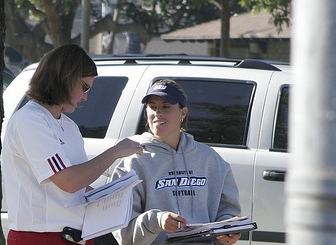

In [ ]:
# test_finetune(8801)
# test_finetune(9834)
test_finetune(5593)


#### custom_classifier_dataset.py : linear SVM 모델을 학습시키기 위한 Custom Dataset 정의
https://github.com/object-detection-algorithm/R-CNN/blob/a7a66144a1809cde728052b4c392ef7d92fdab97/py/utils/data/custom_classifier_dataset.py



In [ ]:
from torch.utils.data import Dataset
class CustomClassifierDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        samples = np.loadtxt(os.path.join(root_dir, 'car.csv'), dtype=np.str)

        jpeg_images = list()
        positive_list = list()
        negative_list = list()
        for idx in range(len(samples)):
            sample_name = samples[idx]
            jpeg_images.append(cv2.imread(os.path.join(root_dir, 'JPEGImages', sample_name + ".jpg")))

            positive_annotation_path = os.path.join(root_dir, 'Annotations', sample_name + '_1.csv')
            positive_annotations = np.loadtxt(positive_annotation_path, dtype=np.int, delimiter=' ')
            # Consider that the csv file is empty or contains only a single label box
            if len(positive_annotations.shape) == 1:
                # Single label frame coordinates
                if positive_annotations.shape[0] == 4:
                    positive_dict = dict()

                    positive_dict['rect'] = positive_annotations
                    positive_dict['image_id'] = idx
                    # positive_dict['image_name'] = sample_name

                    positive_list.append(positive_dict)
            else:
                for positive_annotation in positive_annotations:
                    positive_dict = dict()

                    positive_dict['rect'] = positive_annotation
                    positive_dict['image_id'] = idx
                    # positive_dict['image_name'] = sample_name

                    positive_list.append(positive_dict)

            negative_annotation_path = os.path.join(root_dir, 'Annotations', sample_name + '_0.csv')
            negative_annotations = np.loadtxt(negative_annotation_path, dtype=np.int, delimiter=' ')
            # Consider that the csv file is empty or contains only a single label box
            if len(negative_annotations.shape) == 1:
                # Single label frame coordinates
                if negative_annotations.shape[0] == 4:
                    negative_dict = dict()

                    negative_dict['rect'] = negative_annotations
                    negative_dict['image_id'] = idx
                    # negative_dict['image_name'] = sample_name

                    negative_list.append(negative_dict)
            else:
                for negative_annotation in negative_annotations:
                    negative_dict = dict()

                    negative_dict['rect'] = negative_annotation
                    negative_dict['image_id'] = idx
                    # negative_dict['image_name'] = sample_name

                    negative_list.append(negative_dict)

        self.transform = transform
        self.jpeg_images = jpeg_images
        self.positive_list = positive_list
        self.negative_list = negative_list

    def __getitem__(self, index: int):
        # Position the image to which the subscript belongs
        if index < len(self.positive_list):
            # Positive sample
            target = 1
            positive_dict = self.positive_list[index]

            xmin, ymin, xmax, ymax = positive_dict['rect']
            image_id = positive_dict['image_id']

            image = self.jpeg_images[image_id][ymin:ymax, xmin:xmax]
            cache_dict = positive_dict
        else:
            # Negative sample
            target = 0
            idx = index - len(self.positive_list)
            negative_dict = self.negative_list[idx]

            xmin, ymin, xmax, ymax = negative_dict['rect']
            image_id = negative_dict['image_id']

            image = self.jpeg_images[image_id][ymin:ymax, xmin:xmax]
            cache_dict = negative_dict

        # print('index: %d image_id: %d target: %d image.shape: %s [xmin, ymin, xmax, ymax]: [%d, %d, %d, %d]' %
        #       (index, image_id, target, str(image.shape), xmin, ymin, xmax, ymax))
        if self.transform:
            image = self.transform(image)

        return image, target, cache_dict

    def __len__(self) -> int:
        return len(self.positive_list) + len(self.negative_list)

    def get_transform(self):
        return self.transform

    def get_jpeg_images(self) -> list:
        return self.jpeg_images

    def get_positive_num(self) -> int:
        return len(self.positive_list)

    def get_negative_num(self) -> int:
        return len(self.negative_list)

    def get_positives(self) -> list:
        return self.positive_list

    def get_negatives(self) -> list:
        return self.negative_list

    # Used for hard negative mining
    # Replace negative samples
    def set_negative_list(self, negative_list):
        self.negative_list = negative_list

In [ ]:
from google.colab.patches import cv2_imshow

def test_classifier(idx):
    root_dir = './classifier_car/val'
    train_data_set = CustomClassifierDataset(root_dir)

    print('positive num: %d' % train_data_set.get_positive_num())
    print('negative num: %d' % train_data_set.get_negative_num())
    print('total num: %d' % train_data_set.__len__())

    image, target, cache_dict = train_data_set.__getitem__(idx)
    print('target: %d' % target)
    print('dict: ' + str(cache_dict))

    cv2_imshow(image)
    cv2.waitKey(0)

positive num: 56
negative num: 31044
total num: 31100
target: 1
dict: {'rect': array([113, 170, 150, 203]), 'image_id': 1}


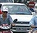

In [ ]:
test_classifier(3)
# test_classifier(317)
# test_classifier(5830)


#### custom_bbox_regression_dataset.py : Bounding box regressor 모델을 학습시키기 위한 Custom Dataset 정의

https://github.com/object-detection-algorithm/R-CNN/blob/a7a66144a1809cde728052b4c392ef7d92fdab97/py/utils/data/create_bbox_regression_data.py

Bounding box regressor의 경우, 이미지 자체를 학습 데이터로 사용하는 것이 아니라 이미지 내의 bounding box의 좌표를 변환시켜주는 값(t_x, t_y)을 학습합니다.


In [ ]:
class BBoxRegressionDataset():
    def __init__(self, root_dir, transform=None):
        super(BBoxRegressionDataset, self).__init__()
        self.transform = transform

        samples = np.loadtxt(os.path.join(root_dir, 'car.csv'), dtype=np.str)
        jpeg_list = list()
        # save {'image_id': ?, 'positive': ?, 'bndbox': ?}
        box_list = list()
        for i in range(len(samples)):
            sample_name = samples[i]

            jpeg_path = os.path.join(root_dir, 'JPEGImages', sample_name + '.jpg')
            bndbox_path = os.path.join(root_dir, 'bndboxs', sample_name + '.csv')
            positive_path = os.path.join(root_dir, 'positive', sample_name + '.csv')

            jpeg_list.append(cv2.imread(jpeg_path))
            bndboxes = np.loadtxt(bndbox_path, dtype=np.int, delimiter=' ')
            positives = np.loadtxt(positive_path, dtype=np.int, delimiter=' ')

            if len(positives.shape) == 1:
                bndbox = self.get_bndbox(bndboxes, positives)
                box_list.append({'image_id': i, 'positive': positives, 'bndbox': bndbox})
            else:
                for positive in positives:
                    bndbox = self.get_bndbox(bndboxes, positive)
                    box_list.append({'image_id': i, 'positive': positive, 'bndbox': bndbox})

        self.jpeg_list = jpeg_list
        self.box_list = box_list

    def __getitem__(self, index: int):
        assert index < self.__len__(), 'The data set size is %d, and the current input subscript is %d' % (self.__len__(), index)

        box_dict = self.box_list[index]
        image_id = box_dict['image_id']
        positive = box_dict['positive']
        bndbox = box_dict['bndbox']

        # Get predicted image
        jpeg_img = self.jpeg_list[image_id]
        xmin, ymin, xmax, ymax = positive
        image = jpeg_img[ymin:ymax, xmin:xmax]

        if self.transform:
            image = self.transform(image)

        # Calculate x/y/w/h of P/G
        target = dict()
        p_w = xmax - xmin
        p_h = ymax - ymin
        p_x = xmin + p_w / 2
        p_y = ymin + p_h / 2

        xmin, ymin, xmax, ymax = bndbox
        g_w = xmax - xmin
        g_h = ymax - ymin
        g_x = xmin + g_w / 2
        g_y = ymin + g_h / 2

        # Calculate t
        t_x = (g_x - p_x) / p_w
        t_y = (g_y - p_y) / p_h
        t_w = np.log(g_w / p_w)
        t_h = np.log(g_h / p_h)

        return image, np.array((t_x, t_y, t_w, t_h))

    def __len__(self):
        return len(self.box_list)

    def get_bndbox(self, bndboxes, positive):
        """
        Return and positive IoU largest label bounding box
        :param bndboxes: The size is [N, 4] or [4]
        :param positive: The size is [4]
        :return: [4]
        """

        if len(bndboxes.shape) == 1:
            # There is only one label bounding box, just go back
            return bndboxes
        else:
            scores = iou(positive, bndboxes)
            return bndboxes[np.argmax(scores)]



In [ ]:
import torchvision.transforms as transforms

def test_bbox():
    """
    Create an instance of the dataset class
    """
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    data_root_dir = './bbox_regression'
    data_set = BBoxRegressionDataset(data_root_dir, transform=transform)

    print(data_set.__len__())
    image, target = data_set.__getitem__(10)
    print(image.shape)
    print(target)
    print(target.dtype)

In [ ]:
test_bbox()

3274
torch.Size([3, 227, 227])
[ 0.041       0.00791139 -0.08555789  0.00944889]
float64



#### custom_batch_sampler.py : 양성/음성 sample을 mini batch로 구성

https://github.com/object-detection-algorithm/R-CNN/blob/a7a66144a1809cde728052b4c392ef7d92fdab97/py/utils/data/custom_batch_sampler.py

양성/음성 sample로 mini batch를 구성합니다. CustomBatchSampler 클래스 생성자에서 양성/음성 sample과 각각의 sample 수를 인자로 받습니다. 반복자(__iter__)에서 양성/음성 sample을 지정된 sample 수에 맞게 저장한 후 shuffle해줍니다. 


In [ ]:
from torch.utils.data import Sampler

class CustomBatchSampler(Sampler):

    def __init__(self, num_positive, num_negative, batch_positive, batch_negative) -> None:
        """
        2 classification data set
        Batch processing each time, including batch_positive positive samples and batch_negative negative samples
        @param num_positive: number of positive samples
        @param num_negative: number of negative samples
        @param batch_positive: the number of positive samples at a time
        @param batch_negative: number of negative samples at a time
        """
        self.num_positive = num_positive
        self.num_negative = num_negative
        self.batch_positive = batch_positive
        self.batch_negative = batch_negative

        length = num_positive + num_negative
        self.idx_list = list(range(length))

        self.batch = batch_negative + batch_positive
        self.num_iter = length // self.batch

    def __iter__(self):
        sampler_list = list()
        for i in range(self.num_iter):
            tmp = np.concatenate(
                (random.sample(self.idx_list[:self.num_positive], self.batch_positive),
                 random.sample(self.idx_list[self.num_positive:], self.batch_negative))
            )
            random.shuffle(tmp)
            sampler_list.extend(tmp)
        return iter(sampler_list)

    def __len__(self) -> int:
        return self.num_iter * self.batch

    def get_num_batch(self) -> int:
        return self.num_iter


In [ ]:
def test_batch():
    root_dir = './finetune_car/train'
    train_data_set = CustomFinetuneDataset(root_dir)
    train_sampler = CustomBatchSampler(train_data_set.get_positive_num(), train_data_set.get_negative_num(), 32, 96)

    print('sampler len: %d' % train_sampler.__len__())
    print('sampler batch num: %d' % train_sampler.get_num_batch())

    first_idx_list = list(train_sampler.__iter__())[:128]
    print(first_idx_list)
    # Number of positive samples in a batch
    print('positive batch: %d' % np.sum(np.array(first_idx_list) < 66517))

In [ ]:
test_batch()

sampler len: 56320
sampler batch num: 440
[53806, 5602, 19482, 19269, 46087, 28714, 45515, 15671, 21431, 2064, 48388, 20578, 32931, 33266, 31979, 327, 45202, 14537, 41948, 1519, 40833, 1570, 39799, 11539, 30686, 1422, 41242, 37606, 28200, 44872, 4626, 46907, 46681, 21800, 19686, 18019, 48837, 50545, 39513, 37404, 6881, 24372, 4925, 46696, 124, 2644, 2784, 20842, 9604, 6819, 14833, 50714, 19249, 54972, 10047, 35102, 4697, 1167, 28434, 32584, 36389, 15111, 51955, 36202, 9122, 32221, 17601, 4038, 52621, 54788, 4073, 31011, 32424, 17063, 5471, 453, 3082, 1129, 48568, 14178, 35135, 36736, 49519, 45408, 1075, 47310, 40132, 49553, 45557, 18833, 6128, 4770, 6794, 54521, 44521, 46037, 14269, 54818, 4654, 30633, 29418, 21659, 50380, 45331, 52493, 2235, 33119, 2487, 694, 1930, 45333, 29164, 46704, 22924, 970, 3651, 2654, 8688, 14504, 15524, 6313, 26642, 3658, 36275, 3637, 50953, 53450, 46241]
positive batch: 128



#### custom_hard_negative_mining_dataset.py : Hard negative mining을 수행하기 위한 Custom Dataset 정의

https://github.com/object-detection-algorithm/R-CNN/blob/a7a66144a1809cde728052b4c392ef7d92fdab97/py/utils/data/custom_hard_negative_mining_dataset.py

In [ ]:
class CustomHardNegativeMiningDataset():
    def __init__(self, negative_list, jpeg_images, transform=None):
        self.negative_list = negative_list
        self.jpeg_images = jpeg_images
        self.transform = transform

    def __getitem__(self, index: int):
        target = 0

        negative_dict = self.negative_list[index]
        xmin, ymin, xmax, ymax = negative_dict['rect']
        image_id = negative_dict['image_id']

        image = self.jpeg_images[image_id][ymin:ymax, xmin:xmax]
        if self.transform:
            image = self.transform(image)

        return image, target, negative_dict

    def __len__(self) -> int:
        return len(self.negative_list)


In [ ]:
root_dir = './classifier_car/train'
data_set = CustomClassifierDataset(root_dir)

negative_list = data_set.get_negatives()
jpeg_images = data_set.get_jpeg_images()
transform = data_set.get_transform()

hard_negative_dataset = CustomHardNegativeMiningDataset(negative_list, jpeg_images, transform=transform)
image, target, negative_dict = hard_negative_dataset.__getitem__(100)

print(image.shape)
print(target)
print(negative_dict)

(465, 500, 3)
0
{'rect': array([  0,  18, 500, 483]), 'image_id': 0}


### 4. pre-trained된 AlexNet fine tuning

3가지 모델 중 AlexNet을 가장 먼저 학습시켜줘야 합니다. linear SVM 및 Bounding box regressor 모델은 fine tune된 AlexNet에 학습 데이터를 입력시켜 얻은 feature vector를 통해 학습하기 때문입니다. 

 


#### finetune.py : 데이터를 load한 후 pre-trained된 AlexNet에 대한 fine tuning 수행

https://github.com/object-detection-algorithm/R-CNN/blob/a7a66144a1809cde728052b4c392ef7d92fdab97/py/finetune.py

먼저 pytorch에서 제공하는 transforms 메서드를 통해 AlexNet의 입력 이미지에 맞게 크기를 227x227로 resize시켜줍니다. 그 다음 CustomFinetuneDataset를 통해 데이터를 load시켜줍니다. 이 때 논문에서 언급한 바와 같이 positive sample은 32개, negative sample은 96개가 되도록 CustomBatchSampler를 통해 지정합니다. 

In [ ]:
from torch.utils.data import DataLoader

def load_data(data_root_dir):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    data_loaders = {}
    data_sizes = {}
    for name in ['train', 'val']:
        data_dir = os.path.join(data_root_dir, name)
        data_set = CustomFinetuneDataset(data_dir, transform=transform)
        data_sampler = CustomBatchSampler(data_set.get_positive_num(), data_set.get_negative_num(), 32, 96)
        data_loader = DataLoader(data_set, batch_size=128, sampler=data_sampler, num_workers=8, drop_last=True)

        data_loaders[name] = data_loader
        data_sizes[name] = data_sampler.__len__()

    return data_loaders, data_sizes

In [ ]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_loaders, data_sizes = load_data('./finetune_car')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import copy

def train_model(data_loaders, model, criterion, optimizer, lr_scheduler, num_epochs=25, device=None):
    since = time.time()

    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                lr_scheduler.step()

            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = running_corrects.double() / data_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_weights)
    return model

In [ ]:
import torchvision.models as models

model = models.alexnet(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


 torchvision에서 제공하는 pre-trained된 AlexNet에서 마지막 layer에 fully connected layer를 추가시켜줍니다. 
 
 이 때 출력되는 output unit의 수는 예측하려는 class의 수 + 1(=배경)입니다. 저희가 살펴보는 코드는 오직 자동차에 대한 분류만 진행하기 때문에 output unit의 수는 2입니다. 

In [ ]:
import torch.nn as nn

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
import torch.optim as optim

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

best_model = train_model(data_loaders, model, criterion, optimizer, lr_scheduler, device=device, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.1853 Acc: 0.9207
val Loss: 0.3800 Acc: 0.8594

Epoch 1/24
----------
train Loss: 0.1068 Acc: 0.9559
val Loss: 0.4457 Acc: 0.8557

Epoch 2/24
----------
train Loss: 0.0911 Acc: 0.9622
val Loss: 0.5120 Acc: 0.8511

Epoch 3/24
----------
train Loss: 0.0769 Acc: 0.9687
val Loss: 0.5261 Acc: 0.8489

Epoch 4/24
----------
train Loss: 0.0678 Acc: 0.9729
val Loss: 0.5080 Acc: 0.8514

Epoch 5/24
----------
train Loss: 0.0638 Acc: 0.9742
val Loss: 0.6506 Acc: 0.8431

Epoch 6/24
----------
train Loss: 0.0557 Acc: 0.9780
val Loss: 0.6839 Acc: 0.8441

Epoch 7/24
----------
train Loss: 0.0459 Acc: 0.9824
val Loss: 0.6375 Acc: 0.8528

Epoch 8/24
----------
train Loss: 0.0473 Acc: 0.9814
val Loss: 0.6461 Acc: 0.8503

Epoch 9/24
----------
train Loss: 0.0465 Acc: 0.9813
val Loss: 0.6474 Acc: 0.8517

Epoch 10/24
----------
train Loss: 0.0459 Acc: 0.9820
val Loss: 0.6505 Acc: 0.8519

Epoch 11/24
----------
train Loss: 0.0447 Acc: 0.9817
val Loss: 0.7078 Acc: 0.8467

Epoch 12/24
----------
t

In [ ]:
# Save the best model parameters
if not os.path.exists('./models'):
  os.mkdir('./models')
torch.save(best_model.state_dict(), 'models/alexnet_car.pth')

##### 모델 저장 후 다음날 다시

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save trained model
if not os.path.exists('/content/drive/alexnet_car.pth'):
  shutil.copyfile('models/alexnet_car.pth', '/content/drive/alexnet_car.pth')

# Save datasets
save_dir = '/content/drive/RCNN_ipynb'
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

for folder in ['finetune_car', 'bbox_regression', 'voc_car', 'models', 'classifier_car']:
  shutil.copytree(os.path.join('.', folder), os.path.join(save_dir, folder))

In [ ]:
import os
import shutil

In [ ]:
# Load
if not os.path.exists('./models'):
  os.mkdir('./models')

save_dir = '/content/drive/MyDrive/RCNN_ipynb'
for folder in ['finetune_car', 'bbox_regression', 'voc_car', 'models', 'classifier_car']:
  if not os.path.exists(os.path.join('.', folder)):
    shutil.copytree(os.path.join(save_dir, folder), os.path.join('.', folder))

### 5. linear SVM 및 Bounding box regressor 학습

#### linear_svm.py : linear SVM 모델 학습(학습 시 hard negative mining 적용)

https://github.com/object-detection-algorithm/R-CNN/blob/a7a66144a1809cde728052b4c392ef7d92fdab97/py/linear_svm.py





linear SVM 모델을 학습하 과정은 AlexNet을 fine tune하는 과정과 유사하지만 몇 가지 차이가 있습니다. 첫 번째로, 학습 초기 데이터를 구성하는 방법에서 차이가 있습니다. Object detection시, 일반적으로 분류하려는 class는 positive sample, 나머지 배경은 negative sample에 해당합니다. 이는 postive sample의 수가 negative sample보다 훨씬 더 적다는 것을 의미합니다. 이러한 클래스 불균형(class imbalance) 상황에서positive/negative sample을 모두 균형있게 학습하기 위해 학습 초기에는 positive sample과 negative sample의 비율을 1:1로 맞춰줍니다. 

In [ ]:
def load_data_svm(data_root_dir):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    data_loaders = {}
    data_sizes = {}
    remain_negative_list = list()
    for name in ['train', 'val']:
        data_dir = os.path.join(data_root_dir, name)
        data_set = CustomClassifierDataset(data_dir, transform=transform)
        if name is 'train':
            positive_list = data_set.get_positives()
            negative_list = data_set.get_negatives()
            init_negative_idxs = random.sample(range(len(negative_list)), len(positive_list))
            init_negative_list = [negative_list[idx] for idx in range(len(negative_list)) if idx in init_negative_idxs]
            data_set.set_negative_list(init_negative_list)

            data_sampler = CustomBatchSampler(data_set.get_positive_num(), data_set.get_negative_num(), 1, 1)
            data_loader = DataLoader(data_set, batch_size=1, sampler=data_sampler, num_workers=8, drop_last=True)
            data_loaders['train'] = data_loader
            data_sizes['train'] = data_sampler.__len__()

            remain_negative_list = [negative_list[idx] for idx in range(len(negative_list))
                                    if idx not in init_negative_idxs]
            data_loaders['remain'] = remain_negative_list
            data_sizes['remain'] = remain_negative_list.__len__()

        if name is 'val':
            data_sampler = CustomBatchSampler(data_set.get_positive_num(), data_set.get_negative_num(), 32, 96)
            data_loader = DataLoader(data_set, batch_size=128, sampler=data_sampler, num_workers=8, drop_last=True)

            data_loaders[name] = data_loader
            data_sizes[name] = data_sampler.__len__()

    return data_loaders, data_sizes

In [ ]:
import torch
import torchvision.transforms as transforms
import numpy as np
import cv2
from torch.utils.data import DataLoader
import random

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

data_loaders, data_sizes = load_data_svm('./classifier_car')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
len(data_loaders['train']), len(data_loaders['val']), len(data_loaders['remain']), data_sizes

(130, 233, 34112, {'remain': 34112, 'train': 130, 'val': 29824})

두 번째로, Hinge loss를 loss function으로 사용합니다.

In [ ]:
def hinge_loss(outputs, labels):
    """
    Folding loss calculation
    :param outputs: the size is (N, num_classes)
    :param labels: size is (N)
    :return: loss value
    """
    num_labels = len(labels)
    corrects = outputs[range(num_labels), labels].unsqueeze(0).T

    # Maximum interval
    margin = 1.0
    margins = outputs - corrects + margin
    loss = torch.sum(torch.max(margins, 1)[0]) / len(labels)

    # Regularization strength
    # reg = 1e-3
    # loss += reg * torch.sum(weight ** 2)

    return loss

마지막으로, 학습 시 Hard negative mining을 적용합니다. 앞서 살펴보았듯이 positive sample과 같은 수로 negative sample을 구성하다보니 많은 negative sample이 남게 됩니다. 이처럼 남은(remain) negative sample은 linear SVM 모델을 한 차례(1 epoch) 학습시킨 후 Hard negative mining에 사용합니다. 

In [ ]:
def add_hard_negatives(hard_negative_list, negative_list, add_negative_list):
    for item in hard_negative_list:
        if len(add_negative_list) == 0:
            # Add negative samples for the first time
            negative_list.append(item)
            add_negative_list.append(list(item['rect']))
        if list(item['rect']) not in add_negative_list:
            negative_list.append(item)
            add_negative_list.append(list(item['rect']))

남은 negative sample은 custom_hard_negative_mining_dataset.py 를 통해 데이터셋으로 구성해준 후 별도로 load시켜 준 후 학습시켜줍니다. 즉, 1 epoch 내에서 positive sample과 negative sample으로 학습시킨 후, 남은 negative sample만으로 모델을 다시 학습시켜주는 셈입니다. 학습 결과 모델이 negative(=배경)이라고 정확히 예측한 경우 True Positive sample이며, positive라고 예측했으나, 실제로는 negative인 경우에는 False Positive sample입니다. 아래는 학습 결과를 토대로 hard negative sample(=False Positive)과 easy negative sample(=True Negative)로 구분하는 코드입니다.  

In [ ]:
def get_hard_negatives(preds, cache_dicts):
    fp_mask = preds == 1
    tn_mask = preds == 0

    fp_rects = cache_dicts['rect'][fp_mask].numpy()
    fp_image_ids = cache_dicts['image_id'][fp_mask].numpy()

    tn_rects = cache_dicts['rect'][tn_mask].numpy()
    tn_image_ids = cache_dicts['image_id'][tn_mask].numpy()

    hard_negative_list = [{'rect': fp_rects[idx], 'image_id': fp_image_ids[idx]} for idx in range(len(fp_rects))]
    easy_negatie_list = [{'rect': tn_rects[idx], 'image_id': tn_image_ids[idx]} for idx in range(len(tn_rects))]

    return hard_negative_list, easy_negatie_list


모델을 남은 negative sample을 학습시켜 찾은 hard negative sample은 negative sample에 추가하여 CustomBatchSampler와 Dataloader를 통해 학습 데이터셋을 다시 구성해줍니다. 즉, 다음 epoch에서는 hard negative sample이 추가된 데이터로 모델을 학습시킬 수 있습니다. 

In [ ]:
import copy

def train_model_svm(data_loaders, model, criterion, optimizer, lr_scheduler, num_epochs=25, device=None):
    since = time.time()

    batch_positive = 32
    batch_negative = 96
    batch_total = 128

    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Number of output positive and negative samples
            data_set = data_loaders[phase].dataset
            print('{} - positive_num: {} - negative_num: {} - data size: {}'.format(
                phase, data_set.get_positive_num(), data_set.get_negative_num(), data_sizes[phase]))

            # Iterate over data.
            for inputs, labels, cache_dicts in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # print(outputs.shape)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                lr_scheduler.step()

            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = running_corrects.double() / data_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())

        # After each round of training is completed, 
        # test the remaining negative sample set and perform hard negative mining
        train_dataset = data_loaders['train'].dataset
        remain_negative_list = data_loaders['remain']
        jpeg_images = train_dataset.get_jpeg_images()
        transform = train_dataset.get_transform()

        with torch.set_grad_enabled(False):
            remain_dataset = CustomHardNegativeMiningDataset(remain_negative_list, jpeg_images, transform=transform)
            remain_data_loader = DataLoader(remain_dataset, batch_size=batch_total, num_workers=8, drop_last=True)

            # Get the negative sample set of the training data set
            negative_list = train_dataset.get_negatives()
            # Record subsequent negative samples added
            add_negative_list = data_loaders.get('add_negative', [])

            running_corrects = 0
            # Iterate over data.
            for inputs, labels, cache_dicts in remain_data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                outputs = model(inputs)
                # print(outputs.shape)
                _, preds = torch.max(outputs, 1)

                running_corrects += torch.sum(preds == labels.data)

                hard_negative_list, easy_neagtive_list = get_hard_negatives(preds.cpu().numpy(), cache_dicts)
                add_hard_negatives(hard_negative_list, negative_list, add_negative_list)

            remain_acc = running_corrects.double() / len(remain_negative_list)
            print('remiam negative size: {}, acc: {:.4f}'.format(len(remain_negative_list), remain_acc))

            # After the training is completed, 
            # reset the negative samples and perform hard negatives mining
            train_dataset.set_negative_list(negative_list)
            tmp_sampler = CustomBatchSampler(train_dataset.get_positive_num(), train_dataset.get_negative_num(),
                                             batch_positive, batch_negative)
            data_loaders['train'] = DataLoader(train_dataset, batch_size=batch_total, sampler=tmp_sampler,
                                               num_workers=8, drop_last=True)
            data_loaders['add_negative'] = add_negative_list
            # Reset the data set size
            data_sizes['train'] = len(tmp_sampler)

        # Save every training round
        if not os.path.exists('./models'):
            os.mkdir('./models')
        torch.save(model.state_dict(), 'models/linear_svm_alexnet_car_%d.pth' % epoch)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_weights)
    return model

In [ ]:
from torchvision.models import alexnet
import torch.nn as nn

# Load the CNN model
model_path = './models/alexnet_car.pth'
model = alexnet()
num_classes = 2
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, num_classes)
model.load_state_dict(torch.load(model_path))
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Fixed feature extraction
for param in model.parameters():
    param.requires_grad = False
# Create SVM classifier
model.classifier[6] = nn.Linear(num_features, num_classes)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
import torch.optim as optim
import time

model = model.to(device)

criterion = hinge_loss
# Since the number of initial training sets is small, the learning rate is reduced
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
# A total of 10 rounds of training, and the learning rate is reduced every 4 sessions
lr_schduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

best_model = train_model_svm(data_loaders, model, criterion, optimizer, lr_schduler, num_epochs=10, device=device)


Epoch 0/9
----------
train - positive_num: 65 - negative_num: 65 - data size: 130


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.1400 Acc: 0.8846
val - positive_num: 57 - negative_num: 29830 - data size: 29824
val Loss: 1.3565 Acc: 0.7844
remiam negative size: 34112, acc: 0.7542
Epoch 1/9
----------
train - positive_num: 65 - negative_num: 8383 - data size: 8448
train Loss: 1.2360 Acc: 0.8263
val - positive_num: 57 - negative_num: 29830 - data size: 29824
val Loss: 1.1293 Acc: 0.9188
remiam negative size: 34112, acc: 0.9796
Epoch 2/9
----------
train - positive_num: 65 - negative_num: 8383 - data size: 8448
train Loss: 1.0725 Acc: 0.9105
val - positive_num: 57 - negative_num: 29830 - data size: 29824
val Loss: 1.1263 Acc: 0.9143
remiam negative size: 34112, acc: 0.9854
Epoch 3/9
----------
train - positive_num: 65 - negative_num: 8383 - data size: 8448
train Loss: 1.0436 Acc: 0.9311
val - positive_num: 57 - negative_num: 29830 - data size: 29824
val Loss: 1.1124 Acc: 0.9177
remiam negative size: 34112, acc: 0.9858
Epoch 4/9
----------
train - positive_num: 65 - negative_num: 8384 - data size: 8448


In [ ]:
# Save the best model parameters
if not os.path.exists('./models'):
    os.mkdir('./models')
torch.save(best_model.state_dict(), 'models/best_linear_svm_alexnet_car.pth')

##### 모델 저장 후 다음날 다시

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save models directory
save_model_dir = '/content/drive/MyDrive/RCNN_ipynb/models'
if not os.path.exists(save_model_dir):
  os.mkdir(save_model_dir)
for file in os.listdir('./models'):
  if not os.path.exists(os.path.join(save_model_dir, file)):
    shutil.copyfile(os.path.join('./models', file), os.path.join(save_model_dir, file))

In [ ]:
import os
import shutil

In [ ]:
# Load
if not os.path.exists('./models'):
  os.mkdir('./models')

save_dir = '/content/drive/MyDrive/RCNN_ipynb'
for folder in ['finetune_car', 'bbox_regression', 'voc_car', 'models', 'classifier_car']:
  if not os.path.exists(os.path.join('.', folder)):
    shutil.copytree(os.path.join(save_dir, folder), os.path.join('.', folder))


#### bbox_regression.py : Bounding box regressor 모델 학습

https://github.com/object-detection-algorithm/R-CNN/blob/a7a66144a1809cde728052b4c392ef7d92fdab97/py/bbox_regression.py



In [ ]:
def load_data_bbox(data_root_dir):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    data_set = BBoxRegressionDataset(data_root_dir, transform=transform)
    data_loader = DataLoader(data_set, batch_size=128, shuffle=True, num_workers=8)

    return data_loader

In [ ]:
data_loader = load_data_bbox('./bbox_regression')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def train_model_bbox(data_loader, feature_model, model, criterion, optimizer, lr_scheduler, num_epochs=25, device=None):
    since = time.time()

    model.train()  # Set model to training mode
    loss_list = list()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0

        # Iterate over data.
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.float().to(device)

            features = feature_model.features(inputs)
            features = torch.flatten(features, 1)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(features)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            lr_scheduler.step()

        epoch_loss = running_loss / data_loader.dataset.__len__()
        loss_list.append(epoch_loss)

        print('{} Loss: {:.4f}'.format(epoch, epoch_loss))

        # Save every training round
        if not os.path.exists('./models'):
          os.mkdir('./models')
        torch.save(model.state_dict(), './models/bbox_regression_%d.pth' % epoch)

    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return loss_list


In [ ]:
def get_model(device=None):
    # Load the CNN model
    model = AlexNet(num_classes=2)
    model.load_state_dict(torch.load('./models/best_linear_svm_alexnet_car.pth'))
    model.eval()

    # Cancel gradient tracking
    for param in model.parameters():
        param.requires_grad = False
    if device:
        model = model.to(device)

    return model

Bounding box regressor를 학습시키는 과정은 상대적으로 단순합니다. fine tuned된 AlexNet 마지막 layer에 output unit = 4인 fully connected layer를 추가해줍니다. 이 때 loss function은 MSE(Mean Squared Error)입니다. 

In [ ]:
from torchvision.models import AlexNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
feature_model = get_model(device)

# The last pooling layer of AlexNet is calculated to get 256*6*6 output
in_features = 256 * 6 * 6
out_features = 4
model = nn.Linear(in_features, out_features)
model.to(device)

Linear(in_features=9216, out_features=4, bias=True)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

loss_list = train_model_bbox(data_loader, feature_model, model, criterion, optimizer, lr_scheduler, device=device,
                        num_epochs=12)

Epoch 0/11
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0 Loss: 0.3596
Epoch 1/11
----------
1 Loss: 0.3357
Epoch 2/11
----------
2 Loss: 0.3295
Epoch 3/11
----------
3 Loss: 0.3319
Epoch 4/11
----------
4 Loss: 0.3270
Epoch 5/11
----------
5 Loss: 0.3290
Epoch 6/11
----------
6 Loss: 0.3331
Epoch 7/11
----------
7 Loss: 0.3309
Epoch 8/11
----------
8 Loss: 0.3317
Epoch 9/11
----------
9 Loss: 0.3310
Epoch 10/11
----------
10 Loss: 0.3366
Epoch 11/11
----------
11 Loss: 0.3356

Training complete in 2m 47s


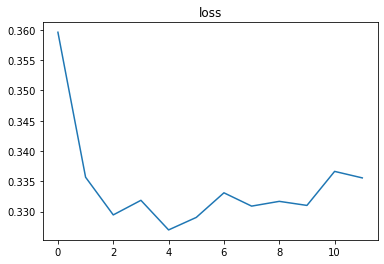

In [ ]:
import matplotlib.pyplot as plt

x = list(range(len(loss_list)))
fg = plt.figure()

plt.plot(x, loss_list)
plt.title('loss')
plt.savefig('./loss.png')

In [ ]:
# Save the best model parameters
if not os.path.exists('./models'):
    os.mkdir('./models')
torch.save(best_model.state_dict(), 'models/best_bbox_regression_alexnet_car.pth')

##### 모델 저장 후 다음날 다시

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Save models directory
save_model_dir = '/content/drive/MyDrive/RCNN_ipynb/models'
if not os.path.exists(save_model_dir):
  os.mkdir(save_model_dir)
for file in os.listdir('./models'):
  if not os.path.exists(os.path.join(save_model_dir, file)):
    shutil.copyfile(os.path.join('./models', file), os.path.join(save_model_dir, file))

In [ ]:
import os
import shutil

In [ ]:
# Load
if not os.path.exists('./models'):
  os.mkdir('./models')

save_dir = '/content/drive/MyDrive/RCNN_ipynb'
for folder in ['finetune_car', 'bbox_regression', 'voc_car', 'models', 'classifier_car']:
  if not os.path.exists(os.path.join('.', folder)):
    shutil.copytree(os.path.join(save_dir, folder), os.path.join('.', folder))

### 6. 학습시킨 모델을 활용하여 detection 수행


#### car_detector.py : fine tuned AlexNet, linear SVM, Bounding box regressor 모델을 활용하여 detection 수행. Non maximum suppression 알고리즘 적용.

https://github.com/object-detection-algorithm/R-CNN/blob/a7a66144a1809cde728052b4c392ef7d92fdab97/py/car_detector.py

먼저 fine tuned된 AlexNet을 통해 얻은 feature vector를 linear SVM 모델에 입력하여 confidence score를 얻습니다. 이 때 svm_threshold = 0.6 으로 지정하여 임계값보다 큰 confidence score를 가지는 bounding box만을 저장합니다. 이후 Non max suppression 알고리즘을 적용하여 최종 detection 결과를 얻습니다. 

In [ ]:
def draw_box_with_text(img, rect_list, score_list):
    """
    Draw the border and its classification probability
    :param img:
    :param rect_list:
    :param score_list:
    :return:
    """
    for i in range(len(rect_list)):
        xmin, ymin, xmax, ymax = rect_list[i]
        score = score_list[i]

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color=(0, 0, 255), thickness=1)
        cv2.putText(img, "{:.3f}".format(score), (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

In [ ]:
def nms(rect_list, score_list):
    """
    Non-maximum suppression
    :param rect_list: list, the size is [N, 4]
    :param score_list: list, size is [N]
    """
    nms_rects = list()
    nms_scores = list()

    rect_array = np.array(rect_list)
    score_array = np.array(score_list)

    # After sorting once
    # Sort by classification probability from largest to smallest
    idxs = np.argsort(score_array)[::-1]
    rect_array = rect_array[idxs]
    score_array = score_array[idxs]

    thresh = 0.3
    while len(score_array) > 0:
        # Add the bounding box with the highest classification probability
        nms_rects.append(rect_array[0])
        nms_scores.append(score_array[0])
        rect_array = rect_array[1:]
        score_array = score_array[1:]

        length = len(score_array)
        if length <= 0:
            break

        # Calculate IoU
        iou_scores = iou(np.array(nms_rects[len(nms_rects) - 1]), rect_array)
        # print(iou_scores)
        # Remove bounding boxes with overlap ratio greater than or equal to thresh
        idxs = np.where(iou_scores < thresh)[0]
        rect_array = rect_array[idxs]
        score_array = score_array[idxs]

    return nms_rects, nms_scores

여기서 IoU treshold = 0.3 으로 지정했습니다. 위의 코드를 보면 임계값보다 작은 bounding box의 index만을 남기는 방식으로 Non maximum suppression 알고리즘을 구현하고 있습니다. 

Suggested number of candidate areas: 1799
[294 195 334 253] tensor([0.0645, 0.6908], device='cuda:0') [0.3483406  0.65165937]
[266 138 314 162] tensor([-0.4347,  0.2384], device='cuda:0') [0.3378092 0.6621908]
[300 141 316 177] tensor([-0.6685,  0.0748], device='cuda:0') [0.3222917 0.6777083]
[161 116 198 162] tensor([-0.0385,  0.5728], device='cuda:0') [0.35174817 0.64825183]
[189 140 213 179] tensor([-0.7586,  0.3541], device='cuda:0') [0.24736392 0.7526361 ]
[254 137 312 178] tensor([-0.6302,  0.1074], device='cuda:0') [0.32353354 0.67646646]
[163 167 204 269] tensor([-0.0789,  0.8192], device='cuda:0') [0.28944188 0.7105581 ]
[181 140 213 179] tensor([-0.6370,  0.3030], device='cuda:0') [0.28090268 0.7190973 ]
[295 186 331 252] tensor([0.1434, 0.8060], device='cuda:0') [0.34015733 0.6598427 ]
detect time: 10 s
[array([189, 140, 213, 179], dtype=int32), array([163, 167, 204, 269], dtype=int32), array([300, 141, 316, 177], dtype=int32), array([254, 137, 312, 178], dtype=int32), array

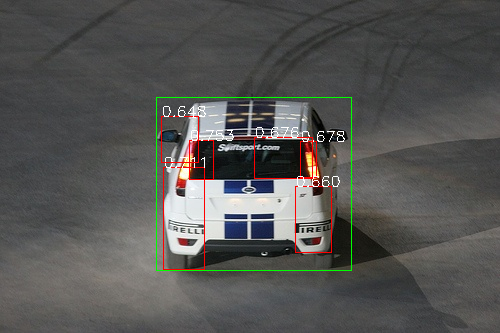

-1

In [ ]:
from google.colab.patches import cv2_imshow

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
transform = transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
model = alexnet()
num_classes = 2
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, num_classes)
model.load_state_dict(torch.load('./models/best_linear_svm_alexnet_car.pth'))
model.eval()

# Cancel gradient tracking
for param in model.parameters():
    param.requires_grad = False
if device:
    model = model.to(device)

# Create selectivesearch object
gs = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

# test_img_path = './VOCdevkit/VOC2007/JPEGImages/000007.jpg'
# test_xml_path = './VOCdevkit/VOC2007/Annotations/000007.xml'
test_img_path = './VOCdevkit/VOC2007/JPEGImages/000012.jpg'
test_xml_path = './VOCdevkit/VOC2007/Annotations/000012.xml'

img = cv2.imread(test_img_path)
dst = copy.deepcopy(img)

bndboxs = parse_xml(test_xml_path)
for bndbox in bndboxs:
    xmin, ymin, xmax, ymax = bndbox
    cv2.rectangle(dst, (xmin, ymin), (xmax, ymax), color=(0, 255, 0), thickness=1)

# Candidate area proposal
gs.setBaseImage(img)
gs.switchToSelectiveSearchFast()
rects = gs.process()
rects[:, 2] += rects[:, 0]
rects[:, 3] += rects[:, 1]
print('Suggested number of candidate areas: %d' % len(rects))

# softmax = torch.softmax()

svm_thresh = 0.60

# Save the positive sample bounding box
score_list = list()
positive_list = list()

# tmp_score_list = list()
# tmp_positive_list = list()
start = time.time()
for rect in rects:
    xmin, ymin, xmax, ymax = rect
    rect_img = img[ymin:ymax, xmin:xmax]

    rect_transform = transform(rect_img).to(device)
    output = model(rect_transform.unsqueeze(0))[0]

    if torch.argmax(output).item() == 1:
        """
        Predicted as car
        """
        probs = torch.softmax(output, dim=0).cpu().numpy()

        # tmp_score_list.append(probs[1])
        # tmp_positive_list.append(rect)

        if probs[1] >= svm_thresh:
            score_list.append(probs[1])
            positive_list.append(rect)
            # cv2.rectangle(dst, (xmin, ymin), (xmax, ymax), color=(0, 0, 255), thickness=2)
            print(rect, output, probs)
end = time.time()
print('detect time: %d s' % (end - start))

# tmp_img2 = copy.deepcopy(dst)
# draw_box_with_text(tmp_img2, tmp_positive_list, tmp_score_list)
# cv2.imshow('tmp', tmp_img2)
#
# tmp_img = copy.deepcopy(dst)
# draw_box_with_text(tmp_img, positive_list, score_list)
# cv2.imshow('tmp2', tmp_img)

nms_rects, nms_scores = nms(positive_list, score_list)
print(nms_rects)
print(nms_scores)
draw_box_with_text(dst, nms_rects, nms_scores)

cv2_imshow(dst)
cv2.waitKey(0)